# Precision at k

This notebook calculates precision at k for the model and the baseline

In [1]:
#import modules

import numpy as np
import pandas as pd
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.prediction_algorithms.knns import KNNBasic
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import KFold
from collections import defaultdict
from surprise.prediction_algorithms.random_pred import NormalPredictor

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

In [2]:
#load data
users = pd.read_csv('goodreads2/user_w_uid_bavg_titles.csv')
div_m = pd.read_csv('goodreads2/div_array.csv')

In [3]:
#load dataset into the correct format
reader = Reader()
rat_data = Dataset.load_from_df(users[['uid', 'bid', 'rating']], reader)
kf = KFold(n_splits=5)

In [4]:
#initialize algorithms

svd = SVD(n_epochs=50)
baseline = NormalPredictor()

In [5]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[int(uid)].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

In [6]:
preclist = []
reclist = []
precbase = []
recbase = []
for k in range(1,11):
    precision = 0
    recall = 0
    precision_base =0
    recall_base=0
    for trainset, testset in kf.split(rat_data):
        svd.fit(trainset)
        predictions = svd.test(testset)
        precisions, recalls = precision_recall_at_k(predictions, k, threshold=3.5)
        
        # Precision and recall averaged over all users for model
        precision += sum(prec for prec in precisions.values()) / len(precisions)
        recall += sum(rec for rec in recalls.values()) / len(recalls)
        
        baseline.fit(trainset)
        pred_baseline = baseline.test(testset)
        precisions_base, recalls_base = precision_recall_at_k(pred_baseline, k, threshold=3.5)
        
        # Precision and recall averaged over all users for baseline
        precision_base += sum(prec for prec in precisions_base.values()) / len(precisions_base)
        recall_base += sum(rec for rec in recalls_base.values()) / len(recalls_base)
    
    #divide by n_splits
    precision /= 5 
    recall /=5
    
    precision_base /= 5
    recall_base /= 5
        
    preclist.append(precision)
    reclist.append(recall)
    
    precbase.append(precision_base)
    recbase.append(recall_base)

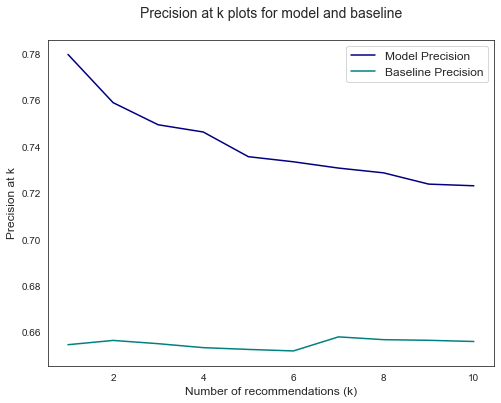

In [7]:
sns.set_style("white")
plt.figure(figsize=(8,6))
plt.plot(list(range(1,11)),preclist,'navy',list(range(1,11)),precbase,'teal')
plt.xlabel('Number of recommendations (k)',fontsize=12)
plt.ylabel('Precision at k',fontsize=12)
plt.title('Precision at k plots for model and baseline\n',fontsize=14)
plt.legend(['Model Precision','Baseline Precision'],loc='best',fontsize=12)
plt.savefig('../eda/precision-1t-k.png',dpi=600)